Space to scratch out the mechanism for running all the processes I want to run on individual ROIs of classified cone mosaic data.

User Inputs (this will eventually be a .yml that the user edits and is read in by the single-mosaic-process executable)

In [1]:
# Paths
# -----
# load and save folder. all coordinate and image data must be in the load folder ()
# if there is already analyses for a mosaic that you want to add analyses to, it must 
# be located in the save file the same name as the coordinate file but with the save file-type
data_path = 'C:\\Users\\schle\Documents\\GitHub\\Incubator-2022-Geometry-of-Color\\CSV data all OCT locs Jan 2022\\'
save_path = 'C:\\Users\\schle\Documents\\Incubator Data\\'

# settings that define the files that will be searched for in the load folder above.
# processes indicated below will be run on all such files found. 
subject = ['AO001R', 'AO008R']
angle = ['temporal', 'nasal', 'superior', 'inferior']
eccentricity = ['1.5', '4', '10']
conetype = ['all','L','M','S','unclassed']
conetype_color = ['y','r','g','b','w']
coord_unit = 'pixels' # units of the coordinate data loaded in - any string you want

# Run settings
# ------------
# select single-mosaic processes to run
# options: 'basic stats', 'intracone_dists', 'monteCarlo_Uniform', 'monteCarlo_coneLocked
proc_to_run = {'intracone_dist', 'monteCarlo_uniform', 'monteCarlo_uniform_intracone_dist'}

# indicate whether all processes requested will be run on all mosaics found fitting the inputs above,
# or processes will only be run for a file if that process' outputs are not present in an identified save file
data_to_run = 'absent_only' # 'all', absent_only

# Process-specific Settings
# -------------------------
# intracone distance settings
dist_area_norm = False # bool

# monteCarlo_uniform and monteCarlo-coneLocked settings
num_mc = 100 # number of monte carlo mosaics to generate

Import packages, some additional hardcoded variables (move these to a settings file eventually), helpful type changes, and variable grouping. 

Some of cell would be contained in a separate configuration file, but most of the content from here on in the notebook needs to be contained in an executable.  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import os
import h5py
import importlib
import glob
import yaml
import sys

import mosaic_topog.utilities as util
import mosaic_topog.flsyst as flsyst
import mosaic_topog.show as show
import mosaic_topog.calc as calc
import mosaic_topog.singleMosaicProcesses as smp

subject = np.asarray(subject)
angle = np.asarray(angle)
eccentricity = np.asarray(eccentricity)

single_mosaic_savefl_config = 'savefl_config.yml'

coord_fltype = '.csv'
img_fltype = '.png'
filetypes = [coord_fltype, img_fltype]

conetype_sizes = [10, 10, 10, 30]


bin_width = 10

categories = [subject, angle, eccentricity]


# set up for "user_param," a dictionary that is passed to the process manager that
# stores all the variables determined from the user's inputs
user_param_keys = [
                   'subject',
                   'angle',
                   'eccentricity',
                   'conetype',
                   'coord_unit',
                   'bin_width',
                   'dist_area_norm',
                   'conetype_color',
                   'num_mc'
                   ]

waitlist = [
            'mosaic',
            'coord_fl_name',
            'coord_index',
            'img_fl_name',
            'img_index',
            'save_name',
            'processes'
            ] # make sure that parameters in this list are set to user_parm downstream

user_param = dict.fromkeys(user_param_keys)
# most of these parameters have been set directly by the user, 
# a few need to be interpreted from the filesystem, however. 
for p in user_param:
    user_param[p] = locals()[p]

Function scratch space

In [3]:
importlib.reload(flsyst)
importlib.reload(smp)
importlib.reload(calc)
importlib.reload(show)

<module 'mosaic_topog.show' from 'c:\\users\\schle\\documents\\github\\incubator-2022-geometry-of-color\\mosaic_topog\\mosaic_topog\\show.py'>

Get all possible coordinate filenames based on the user inputs and find the ones that exist in the folder. 

In [4]:
# fl_name is the output variable we care about for now -
#     it's a list of all files found for combinations of the input parameters.

# mosaic is a list of all the classified mosaics the located data come from
# for instance a single mosaic may be mapped to mosaic coordinate files for 
# L, M, S, 'all', and 'unclassed' cone sub-mosaics 

# index is a dictionary for indexing through the list flnames according to:
#     inputs to single_mosaic_processes - subject, angle, eccentricity, conetype_ids 
#     determined by single_mosaic_processes - 

mosaic, coord_fl_name, coord_index = flsyst.getFilesByDataGroup(data_path, user_param, '.csv')
img_mosaic, img_fl_name, img_index = flsyst.getFilesByDataGroup(data_path, user_param, '.png')

# Make list of expected save-file names for this data
save_name = flsyst.saveNameFromLoadPath(coord_fl_name,save_path)


found 110 files

found 22 files



Load in the configuration file that determines the Single_mosaic_processes save file structure

In [5]:
sav_cfg = flsyst.readYaml(single_mosaic_savefl_config)
for key in sav_cfg.keys():
    print(key)
    print(sav_cfg[key])
    print('')

mandatory_proc
['meta', 'input_data']

order_optional_proc
['intracone_dist', 'monteCarlo_uniform', 'monteCarlo_uniform_intracone_dist']

meta
{'process': 'meta_process', 'variables': ['mosaic', 'subject', 'angle', 'eccentricity', 'conetype']}

input_data
{'process': 'input_data_process', 'variables': ['cone_img', 'cone_coord', 'coord_unit', 'conetype_color', 'bin_width', 'dist_area_norm', 'num_mc']}

intracone_dist
{'process': 'intracone_dist_process', 'variables': ['dist', 'mean_nearest', 'std_nearest', 'hist', 'bin_edge', 'annulus_area']}

monteCarlo_uniform
{'process': 'monteCarlo_uniform_process', 'variables': ['coord']}

monteCarlo_uniform_intracone_dist
{'process': 'monteCarlo_uniform_intracone_dist_process', 'dependency': None, 'variables': ['dist', 'mean_nearest', 'std_nearest', 'hist', 'bin_edge', 'annulus_area', 'mean_dist_hist', 'std_dist_hist']}



If we want to run all the data, start processes.  Otherwise, read from the save folder to determine which data needs to be run through which processes -- then start processes. 

In [6]:
if data_to_run == 'all':
    processes = {}
    for proc in proc_to_run:
        processes[proc] = np.arange(0,len(coord_fl_name)).tolist()
elif data_to_run == 'absent_only':
    processes = flsyst.getProcessesToRun(save_name, save_path, proc_to_run, sav_cfg)


In [7]:
print(processes)

for p in waitlist:
    user_param[p] = vars()[p]
    
# for p in user_param:
#     print(p)
#     print(user_param[p])
#     print('')

{'intracone_dist': array([], dtype=int32), 'monteCarlo_uniform': array([], dtype=int32), 'monteCarlo_uniform_intracone_dist': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109])}


In [8]:
smp.runSingleMosaicProcess(user_param, sav_cfg)

cone_img
(225, 244)

cone_coord
(1470, 2)

cone_img
(225, 244)

cone_coord
(960, 2)

cone_img
(225, 244)

cone_coord
(430, 2)

cone_img
(225, 244)

cone_coord
(80, 2)

cone_img
(225, 244)

cone_coord
(0,)

cone_img
(293, 356)

cone_coord
(548, 2)

cone_img
(293, 356)

cone_coord
(373, 2)

cone_img
(293, 356)

cone_coord
(130, 2)

cone_img
(293, 356)

cone_coord
(44, 2)

cone_img
(293, 356)

cone_coord
(2,)

cone_img
(420, 260)

cone_coord
(2323, 2)

cone_img
(420, 260)

cone_coord
(1471, 2)

cone_img
(420, 260)

cone_coord
(693, 2)

cone_img
(420, 260)

cone_coord
(138, 2)

cone_img
(420, 260)

cone_coord
(21, 2)

cone_img
(507, 366)



c:\users\schle\documents\github\incubator-2022-geometry-of-color\mosaic_topog\mosaic_topog\singleMosaicProcesses.py:182: UserWarning: loadtxt: Empty input file: "C:\Users\schle\Documents\GitHub\Incubator-2022-Geometry-of-Color\CSV data all OCT locs Jan 2022\AO001R_temporal_1.5_unclassed.csv"
  data_to_set[var] = (np.loadtxt(param['coord_fl'], delimiter=','))


cone_coord
(1655, 2)

cone_img
(507, 366)

cone_coord
(1087, 2)

cone_img
(507, 366)

cone_coord
(445, 2)

cone_img
(507, 366)

cone_coord
(115, 2)

cone_img
(507, 366)

cone_coord
(8, 2)

cone_img
(495, 368)

cone_coord
(872, 2)

cone_img
(495, 368)

cone_coord
(524, 2)

cone_img
(495, 368)

cone_coord
(228, 2)

cone_img
(495, 368)

cone_coord
(95, 2)

cone_img
(495, 368)

cone_coord
(25, 2)

cone_img
(502, 288)

cone_coord
(1965, 2)

cone_img
(502, 288)

cone_coord
(1307, 2)

cone_img
(502, 288)

cone_coord
(539, 2)

cone_img
(502, 288)

cone_coord
(97, 2)

cone_img
(502, 288)

cone_coord
(22, 2)

cone_img
(421, 383)

cone_coord
(1215, 2)

cone_img
(421, 383)

cone_coord
(781, 2)

cone_img
(421, 383)

cone_coord
(352, 2)

cone_img
(421, 383)

cone_coord
(69, 2)

cone_img
(421, 383)

cone_coord
(13, 2)

cone_img
(298, 264)

cone_coord
(447, 2)

cone_img
(298, 264)

cone_coord
(276, 2)

cone_img
(298, 264)

cone_coord
(138, 2)

cone_img
(298, 264)

cone_coord
(30, 2)

cone_img
(298, 26

[[[ -1.         157.7584313  177.11882604 ... 168.42310508 105.23542022
   150.15549109]
  [157.7584313   -1.          37.44298514 ...  11.028892    78.3930059
   220.14751366]
  [177.11882604  37.44298514  -1.         ...  37.11137961  80.34058194
   255.34749517]
  ...
  [168.42310508  11.028892    37.11137961 ...  -1.          88.7812952
   226.14392771]
  [105.23542022  78.3930059   80.34058194 ...  88.7812952   -1.
   219.40963866]
  [150.15549109 220.14751366 255.34749517 ... 226.14392771 219.40963866
    -1.        ]]

 [[ -1.          48.52902467 132.88288985 ... 168.48535355  48.4450469
    73.53833173]
  [ 48.52902467  -1.         115.28762636 ... 145.37031678  16.88708521
    99.99522004]
  [132.88288985 115.28762636  -1.         ...  37.55702147  99.6654517
   102.06187891]
  ...
  [168.48535355 145.37031678  37.55702147 ...  -1.         131.12186977
   138.98473867]
  [ 48.4450469   16.88708521  99.6654517  ... 131.12186977  -1.
    86.7817105 ]
  [ 73.53833173  99.9952200

[[[ -1.         212.83003644 282.69037668 ... 276.54409497 307.59515627
   129.50607964]
  [212.83003644  -1.         302.84264252 ... 190.40943485 364.78857393
   183.00863732]
  [282.69037668 302.84264252  -1.         ... 146.88374546  72.06372588
   161.18466276]
  ...
  [276.54409497 190.40943485 146.88374546 ...  -1.         218.82765899
   155.50424563]
  [307.59515627 364.78857393  72.06372588 ... 218.82765899  -1.
   202.9569674 ]
  [129.50607964 183.00863732 161.18466276 ... 155.50424563 202.9569674
    -1.        ]]

 [[ -1.          49.65652853 165.86214294 ...  98.60810702  76.4868992
   198.82911731]
  [ 49.65652853  -1.         171.03229219 ... 127.33990265  75.5576905
   204.00486881]
  [165.86214294 171.03229219  -1.         ... 260.02793091  95.75682651
    33.27020603]
  ...
  [ 98.60810702 127.33990265 260.02793091 ...  -1.         174.97913584
   292.0719937 ]
  [ 76.4868992   75.5576905   95.75682651 ... 174.97913584  -1.
   128.91498951]
  [198.82911731 204.004868

[[[ -1.          89.24438263 267.80636478 ... 106.92763791 124.72207355
   363.32848776]
  [ 89.24438263  -1.         182.55166277 ... 139.60434533  37.03157391
   291.9446681 ]
  [267.80636478 182.55166277  -1.         ... 263.56119943 156.36530518
   137.79831369]
  ...
  [106.92763791 139.60434533 263.56119943 ...  -1.         172.61564605
   319.52282655]
  [124.72207355  37.03157391 156.36530518 ... 172.61564605  -1.
   276.28163408]
  [363.32848776 291.9446681  137.79831369 ... 319.52282655 276.28163408
    -1.        ]]

 [[ -1.         315.97232449 203.62258852 ... 394.86646363 381.43552357
   317.77823285]
  [315.97232449  -1.         141.84264032 ... 131.75754729 139.70383716
   184.81540815]
  [203.62258852 141.84264032  -1.         ... 191.63494865 177.85801276
   130.44491056]
  ...
  [394.86646363 131.75754729 191.63494865 ...  -1.          26.05112808
   128.69184347]
  [381.43552357 139.70383716 177.85801276 ...  26.05112808  -1.
   103.35670192]
  [317.77823285 184.815

mean_nearest
(10,)

std_nearest
(10,)

hist
(10, 48)

bin_edge
(49,)

annulus_area
(48,)

mean_dist_hist
(48,)

std_dist_hist
(48,)

C:\Users\schle\Documents\Incubator Data\AO001R_nasal_1.5_unclassed.hdf5
[[[ -1.         161.4798845  266.1589086  ... 263.15445787  61.77854657
   273.20303604]
  [161.4798845   -1.         135.47790201 ... 120.2733435  214.57869117
   170.91864359]
  [266.1589086  135.47790201  -1.         ...  27.91857035 326.83854585
    56.46187643]
  ...
  [263.15445787 120.2733435   27.91857035 ...  -1.         322.46963553
    84.19800641]
  [ 61.77854657 214.57869117 326.83854585 ... 322.46963553  -1.
   334.98152971]
  [273.20303604 170.91864359  56.46187643 ...  84.19800641 334.98152971
    -1.        ]]

 [[ -1.         148.61072329 212.09918631 ... 128.26199287 120.25047154
   191.9013469 ]
  [148.61072329  -1.          84.23104612 ...  40.65459805 235.04407837
   141.12741679]
  [212.09918631  84.23104612  -1.         ...  84.37067504 313.41069454
   102.7996

[[[ -1.         434.57333268 235.03619435 ... 229.10620565 470.30538684
   277.38715029]
  [434.57333268  -1.         342.02470696 ... 240.432473   182.8448711
   157.30506284]
  [235.03619435 342.02470696  -1.         ... 280.47458346 465.79548382
   221.95364687]
  ...
  [229.10620565 240.432473   280.47458346 ...  -1.         241.19938184
   114.75700985]
  [470.30538684 182.8448711  465.79548382 ... 241.19938184  -1.
   244.0610448 ]
  [277.38715029 157.30506284 221.95364687 ... 114.75700985 244.0610448
    -1.        ]]

 [[ -1.          67.86580285 235.35380726 ... 195.68617264 286.29471548
   135.61792171]
  [ 67.86580285  -1.         228.02909833 ... 153.79793653 237.75727223
   201.57431607]
  [235.35380726 228.02909833  -1.         ... 372.06363726 168.85453568
   326.84041815]
  ...
  [195.68617264 153.79793653 372.06363726 ...  -1.         326.30596117
   288.15795523]
  [286.29471548 237.75727223 168.85453568 ... 326.30596117  -1.
   414.72324485]
  [135.61792171 201.57431

[[[ -1.         314.22612117 154.88367486 ... 118.8136502  321.38030603
   280.43894761]
  [314.22612117  -1.         440.68200489 ... 235.97919847  47.82983785
   394.47796583]
  [154.88367486 440.68200489  -1.         ... 273.62180239 457.8153993
   228.02498096]
  ...
  [118.8136502  235.97919847 273.62180239 ...  -1.         228.66711528
   359.16563321]
  [321.38030603  47.82983785 457.8153993  ... 228.66711528  -1.
   431.80656625]
  [280.43894761 394.47796583 228.02498096 ... 359.16563321 431.80656625
    -1.        ]]

 [[ -1.         188.59186308 278.75133101 ... 353.67924639 105.50970937
   308.18914692]
  [188.59186308  -1.         194.41600071 ... 165.69177673  86.01997232
   135.47926552]
  [278.75133101 194.41600071  -1.         ... 262.63907174 231.4931732
   149.47587217]
  ...
  [353.67924639 165.69177673 262.63907174 ...  -1.         248.97164729
   114.47351203]
  [105.50970937  86.01997232 231.4931732  ... 248.97164729  -1.
   216.35552218]
  [308.18914692 135.47926

[[[ -1.         257.50296231 373.26973108 ... 355.69872217 169.87778312
   158.99552158]
  [257.50296231  -1.         196.4661106  ... 163.5065238  113.25933224
   146.22822361]
  [373.26973108 196.4661106   -1.         ...  34.76678919 207.99148824
   326.21962529]
  ...
  [355.69872217 163.5065238   34.76678919 ...  -1.         187.14998686
   297.36847044]
  [169.87778312 113.25933224 207.99148824 ... 187.14998686  -1.
   141.23520867]
  [158.99552158 146.22822361 326.21962529 ... 297.36847044 141.23520867
    -1.        ]]

 [[ -1.          61.85601915  34.89876432 ... 180.25900739 194.85654867
   293.6633906 ]
  [ 61.85601915  -1.          85.48580436 ... 203.4405923  144.02697828
   232.16976072]
  [ 34.89876432  85.48580436  -1.         ... 147.57629103 199.42936459
   310.6062639 ]
  ...
  [180.25900739 203.4405923  147.57629103 ...  -1.         225.99901292
   364.38398541]
  [194.85654867 144.02697828 199.42936459 ... 225.99901292  -1.
   139.17242725]
  [293.6633906  232.169

[[[ -1.         322.33090231 129.7249254  ... 211.90141103 170.73838443
   145.86234117]
  [322.33090231  -1.         417.83750769 ... 224.06700497 181.08504968
   332.47920596]
  [129.7249254  417.83750769  -1.         ... 341.17001662 293.17799059
   115.32500228]
  ...
  [211.90141103 224.06700497 341.17001662 ...  -1.          76.24744413
   318.59436143]
  [170.73838443 181.08504968 293.17799059 ...  76.24744413  -1.
   252.3387405 ]
  [145.86234117 332.47920596 115.32500228 ... 318.59436143 252.3387405
    -1.        ]]

 [[ -1.         291.77042269  87.19467349 ... 242.95506977  66.3505095
   237.82592663]
  [291.77042269  -1.         361.56467435 ...  77.92916255 357.13544562
   145.65290901]
  [ 87.19467349 361.56467435  -1.         ... 301.75878825  70.59607262
   278.13257666]
  ...
  [242.95506977  77.92916255 301.75878825 ...  -1.         309.26884458
    69.83811942]
  [ 66.3505095  357.13544562  70.59607262 ... 309.26884458  -1.
   301.39266225]
  [237.82592663 145.65290

[[[ -1.         194.16989949 223.67795562 ... 257.60566179 259.48949615
   291.31946088]
  [194.16989949  -1.         109.34457822 ...  90.94633069 127.73975225
   149.77796639]
  [223.67795562 109.34457822  -1.         ...  62.3412974   36.03638787
    67.98459258]
  ...
  [257.60566179  90.94633069  62.3412974  ...  -1.          52.07634857
    62.31271225]
  [259.48949615 127.73975225  36.03638787 ...  52.07634857  -1.
    31.94943681]
  [291.31946088 149.77796639  67.98459258 ...  62.31271225  31.94943681
    -1.        ]]

 [[ -1.          88.59724786  61.12765806 ... 154.11325791 198.77609203
   119.87545301]
  [ 88.59724786  -1.         143.25407761 ...  66.51595308 111.35022689
    72.08560083]
  [ 61.12765806 143.25407761  -1.         ... 209.76557933 247.96107599
   180.96994378]
  ...
  [154.11325791  66.51595308 209.76557933 ...  -1.          58.90047128
    80.5115996 ]
  [198.77609203 111.35022689 247.96107599 ...  58.90047128  -1.
   139.36909846]
  [119.87545301  72.085

[[[ -1.         246.58321937 323.56233444 ... 351.84428125 353.19994955
   429.61236963]
  [246.58321937  -1.          77.08731854 ... 105.87963927 114.1806544
   186.27423414]
  [323.56233444  77.08731854  -1.         ...  33.50651386  51.35277312
   111.45054988]
  ...
  [351.84428125 105.87963927  33.50651386 ...  -1.          62.46656044
    96.07142225]
  [353.19994955 114.1806544   51.35277312 ...  62.46656044  -1.
    77.43347745]
  [429.61236963 186.27423414 111.45054988 ...  96.07142225  77.43347745
    -1.        ]]

 [[ -1.          72.40230407 177.39949418 ... 276.83944262 115.35040442
   258.02219503]
  [ 72.40230407  -1.         191.62697018 ... 329.41284259 186.78219527
   301.97959777]
  [177.39949418 191.62697018  -1.         ... 186.20649626 230.77051712
   419.88990277]
  ...
  [276.83944262 329.41284259 186.20649626 ...  -1.         241.54987926
   430.47484127]
  [115.35040442 186.78219527 230.77051712 ... 241.54987926  -1.
   197.80233105]
  [258.02219503 301.9795

[[[ -1.          56.84878669  51.31268522 ... 211.03466007 451.08970984
   376.47627609]
  [ 56.84878669  -1.          87.88725841 ... 174.68492655 410.40511641
   330.76579064]
  [ 51.31268522  87.88725841  -1.         ... 257.6785915  496.31519886
   418.30808186]
  ...
  [211.03466007 174.68492655 257.6785915  ...  -1.         240.37568039
   172.86761497]
  [451.08970984 410.40511641 496.31519886 ... 240.37568039  -1.
    93.74546071]
  [376.47627609 330.76579064 418.30808186 ... 172.86761497  93.74546071
    -1.        ]]

 [[ -1.         167.23937438  98.94960718 ... 122.35718977 241.70579504
   241.22128217]
  [167.23937438  -1.         231.75492731 ... 140.54176196 119.76645132
   140.10598632]
  [ 98.94960718 231.75492731  -1.         ... 221.03601501 264.08663831
   251.55964478]
  ...
  [122.35718977 140.54176196 221.03601501 ...  -1.         256.20042128
   270.37388974]
  [241.70579504 119.76645132 264.08663831 ... 256.20042128  -1.
    31.49524227]
  [241.22128217 140.105

mean_nearest
(10,)

std_nearest
(10,)

hist
(10, 63)

bin_edge
(64,)

annulus_area
(62,)

mean_dist_hist
(63,)

std_dist_hist
(63,)

C:\Users\schle\Documents\Incubator Data\AO001R_inferior_4_L.hdf5
[[[ -1.          82.28295525 397.83968099 ... 244.67677435 257.58047217
   409.44975401]
  [ 82.28295525  -1.         373.07327708 ... 190.79735093 296.8905697
   394.69855274]
  [397.83968099 373.07327708  -1.         ... 205.6037354  277.9701102
    52.10187187]
  ...
  [244.67677435 190.79735093 205.6037354  ...  -1.         286.21468008
   242.36207362]
  [257.58047217 296.8905697  277.9701102  ... 286.21468008  -1.
   255.20139356]
  [409.44975401 394.69855274  52.10187187 ... 242.36207362 255.20139356
    -1.        ]]

 [[ -1.         330.76314266 172.71150284 ... 266.90316034 225.11788593
   278.30176373]
  [330.76314266  -1.         494.99480147 ...  81.99691781 491.90369501
   163.75664961]
  [172.71150284 494.99480147  -1.         ... 423.25330461 255.84151697
   408.29319483]
  .

[[[ -1.         182.89399954 376.26173527 ... 360.02097998 276.72125404
   244.78977826]
  [182.89399954  -1.         426.87670113 ... 334.44481434 344.89055487
   324.60642973]
  [376.26173527 426.87670113  -1.         ... 165.65740649 100.21377229
   133.80785986]
  ...
  [360.02097998 334.44481434 165.65740649 ...  -1.         173.69160909
   194.42126685]
  [276.72125404 344.89055487 100.21377229 ... 173.69160909  -1.
    34.11125405]
  [244.78977826 324.60642973 133.80785986 ... 194.42126685  34.11125405
    -1.        ]]

 [[ -1.         192.60199357 510.34466931 ... 250.20616152  75.01482657
    94.6387951 ]
  [192.60199357  -1.         350.50036803 ...  59.73857073 171.21951165
   149.1248718 ]
  [510.34466931 350.50036803  -1.         ... 324.24752868 515.3786762
   424.02070486]
  ...
  [250.20616152  59.73857073 324.24752868 ...  -1.         220.14429556
   208.05590929]
  [ 75.01482657 171.21951165 515.3786762  ... 220.14429556  -1.
   140.72643565]
  [ 94.6387951  149.1248

[[[ -1.         357.02808473 295.8215107  ... 149.82651582 257.68075767
    74.76290251]
  [357.02808473  -1.         404.66981143 ... 221.91574407  99.80626699
   386.46246543]
  [295.8215107  404.66981143  -1.         ... 246.22134558 335.10907649
   235.60314812]
  ...
  [149.82651582 221.91574407 246.22134558 ...  -1.         124.10531878
   165.07976162]
  [257.68075767  99.80626699 335.10907649 ... 124.10531878  -1.
   287.37984551]
  [ 74.76290251 386.46246543 235.60314812 ... 165.07976162 287.37984551
    -1.        ]]

 [[ -1.         166.21841744 231.4673956  ... 129.76764245 270.84520627
   279.55084151]
  [166.21841744  -1.         209.74427287 ... 149.85282149 347.13818385
   125.66918118]
  [231.4673956  209.74427287  -1.         ... 101.83891909 181.5027503
   206.92736827]
  ...
  [129.76764245 149.85282149 101.83891909 ...  -1.         197.37258078
   208.68419418]
  [270.84520627 347.13818385 181.5027503  ... 197.37258078  -1.
   382.55780447]
  [279.55084151 125.6691

[[[ -1.         252.12790788 145.72243707 ... 168.07441827 207.98604017
   440.58119216]
  [252.12790788  -1.         314.3198563  ... 297.8236949  190.25144156
   296.80855679]
  [145.72243707 314.3198563   -1.         ...  42.09334975 168.16093196
   390.61368135]
  ...
  [168.07441827 297.8236949   42.09334975 ...  -1.         134.63766413
   350.12970724]
  [207.98604017 190.25144156 168.16093196 ... 134.63766413  -1.
   235.87444764]
  [440.58119216 296.80855679 390.61368135 ... 350.12970724 235.87444764
    -1.        ]]

 [[ -1.         147.60907828 165.62844571 ... 199.77691746 244.91873181
    41.99988707]
  [147.60907828  -1.          76.65533893 ... 269.03300974 243.21486487
   108.94835085]
  [165.62844571  76.65533893  -1.         ... 328.76490643 317.1436191
   140.4747671 ]
  ...
  [199.77691746 269.03300974 328.76490643 ...  -1.         118.4481452
   197.50734559]
  [244.91873181 243.21486487 317.1436191  ... 118.4481452   -1.
   221.6727874 ]
  [ 41.99988707 108.94835

[[[ -1.          80.70056544 241.93891339 ... 205.61482724 151.03672009
   316.97351277]
  [ 80.70056544  -1.         184.3140516  ... 126.22248338  84.62104942
   246.3569295 ]
  [241.93891339 184.3140516   -1.         ... 118.16508728 216.5519617
    94.9930579 ]
  ...
  [205.61482724 126.22248338 118.16508728 ...  -1.         113.17052195
   134.83343302]
  [151.03672009  84.62104942 216.5519617  ... 113.17052195  -1.
   247.95490563]
  [316.97351277 246.3569295   94.9930579  ... 134.83343302 247.95490563
    -1.        ]]

 [[ -1.         178.30405408 231.4725648  ...  52.96228946 205.45013403
   146.40862331]
  [178.30405408  -1.          53.16853703 ... 131.3499231   67.48909976
   141.84517119]
  [231.4725648   53.16853703  -1.         ... 184.03959396  75.1091165
   178.94471577]
  ...
  [ 52.96228946 131.3499231  184.03959396 ...  -1.         152.73136936
   141.2638601 ]
  [205.45013403  67.48909976  75.1091165  ... 152.73136936  -1.
   205.68227165]
  [146.40862331 141.84517

[[[ -1.         173.72216568 262.67963487 ... 323.60478269 182.64943278
   195.77104026]
  [173.72216568  -1.         253.89503989 ... 214.26807742 105.97288107
   181.07551889]
  [262.67963487 253.89503989  -1.         ... 467.58439482 148.42650094
    76.3781943 ]
  ...
  [323.60478269 214.26807742 467.58439482 ...  -1.         319.16404694
   395.34068423]
  [182.64943278 105.97288107 148.42650094 ... 319.16404694  -1.
    79.21319454]
  [195.77104026 181.07551889  76.3781943  ... 395.34068423  79.21319454
    -1.        ]]

 [[ -1.         399.92263833  86.63350978 ... 105.59902326 441.72206483
   109.47941283]
  [399.92263833  -1.         404.0548478  ... 311.55685932 136.85614323
   453.22769207]
  [ 86.63350978 404.0548478   -1.         ... 162.74074902 418.12063212
    49.33700907]
  ...
  [105.59902326 311.55685932 162.74074902 ...  -1.         377.09901718
   202.9194774 ]
  [441.72206483 136.85614323 418.12063212 ... 377.09901718  -1.
   463.6215652 ]
  [109.47941283 453.227

[[[ -1.         257.9562119  347.28820725 ... 296.18191245 141.25986293
   222.51460009]
  [257.9562119   -1.          90.11747896 ... 115.97933734 120.70535814
   257.15927642]
  [347.28820725  90.11747896  -1.         ... 148.56375401 210.7890008
   312.15906152]
  ...
  [296.18191245 115.97933734 148.56375401 ...  -1.         162.29540384
   361.24985486]
  [141.25986293 120.70535814 210.7890008  ... 162.29540384  -1.
   227.16608437]
  [222.51460009 257.15927642 312.15906152 ... 361.24985486 227.16608437
    -1.        ]]

 [[ -1.         130.86996322 396.7728795  ... 393.1696381  139.50616765
   222.34185006]
  [130.86996322  -1.         295.14805197 ... 323.41365381  49.65739354
   119.2669251 ]
  [396.7728795  295.14805197  -1.         ... 114.4129497  333.22417728
   177.87182187]
  ...
  [393.1696381  323.41365381 114.4129497  ...  -1.         369.84777649
   208.62031586]
  [139.50616765  49.65739354 333.22417728 ... 369.84777649  -1.
   162.52365946]
  [222.34185006 119.2669

mean_nearest
(10,)

std_nearest
(10,)

hist
(10, 67)

bin_edge
(68,)

annulus_area
(66,)

mean_dist_hist
(67,)

std_dist_hist
(67,)

C:\Users\schle\Documents\Incubator Data\AO008R_nasal_4_L.hdf5
[[[ -1.         326.35534446 315.06293249 ... 421.79818376 446.05533967
   157.73825149]
  [326.35534446  -1.          20.94359638 ... 135.13410232 141.36343286
   186.81658536]
  [315.06293249  20.94359638  -1.         ... 129.92129917 161.45351855
   170.96833311]
  ...
  [421.79818376 135.13410232 129.92129917 ...  -1.         197.57424445
   265.26127286]
  [446.05533967 141.36343286 161.45351855 ... 197.57424445  -1.
   322.73697962]
  [157.73825149 186.81658536 170.96833311 ... 265.26127286 322.73697962
    -1.        ]]

 [[ -1.         366.92294895 110.88672812 ... 329.34990993 274.18662159
   238.34248477]
  [366.92294895  -1.         357.6518334  ... 275.8743672   94.13934961
   285.94339169]
  [110.88672812 357.6518334   -1.         ... 400.39370878 265.07991346
   318.42403835]
  ..

[[[ -1.         169.79643103 298.19960741 ... 246.5364854  326.72919398
   180.30049307]
  [169.79643103  -1.         128.87134689 ... 212.77422812 256.40106739
   253.9759945 ]
  [298.19960741 128.87134689  -1.         ... 279.30204823 283.80818172
   363.61884937]
  ...
  [246.5364854  212.77422812 279.30204823 ...  -1.          87.42325419
   142.86988208]
  [326.72919398 256.40106739 283.80818172 ...  87.42325419  -1.
   227.30225169]
  [180.30049307 253.9759945  363.61884937 ... 142.86988208 227.30225169
    -1.        ]]

 [[ -1.          85.23610658 223.14950754 ...  31.5947983  259.60146364
   255.62285999]
  [ 85.23610658  -1.         268.74959687 ...  66.65094335 193.06186182
   336.47005452]
  [223.14950754 268.74959687  -1.         ... 213.70115339 315.19516364
   186.49074857]
  ...
  [ 31.5947983   66.65094335 213.70115339 ...  -1.         228.85209901
   269.97475126]
  [259.60146364 193.06186182 315.19516364 ... 228.85209901  -1.
   459.80775015]
  [255.62285999 336.470

[[[ -1.         151.4522675   88.77361062 ... 305.97047155 376.57662859
   117.961495  ]
  [151.4522675   -1.         205.74071632 ... 196.15218407 341.73919988
    73.73796743]
  [ 88.77361062 205.74071632  -1.         ... 307.63632434 326.95775326
   143.73785318]
  ...
  [305.97047155 196.15218407 307.63632434 ...  -1.         202.86810842
   188.51076061]
  [376.57662859 341.73919988 326.95775326 ... 202.86810842  -1.
   290.65026581]
  [117.961495    73.73796743 143.73785318 ... 188.51076061 290.65026581
    -1.        ]]

 [[ -1.         162.62425536 196.00666103 ... 308.70675204  90.93264295
   104.27206897]
  [162.62425536  -1.         131.4916119  ... 192.66832714 223.68316524
    80.68841793]
  [196.00666103 131.4916119   -1.         ... 119.36745498 200.42107935
   101.02304206]
  ...
  [308.70675204 192.66832714 119.36745498 ...  -1.         319.73607262
   205.90446211]
  [ 90.93264295 223.68316524 200.42107935 ... 319.73607262  -1.
   145.88623089]
  [104.27206897  80.688

[[[ -1.         331.73928019 436.79716454 ... 167.04078079 360.30477613
   228.20588173]
  [331.73928019  -1.         156.8284667  ... 265.53944001  29.06203169
   203.89549456]
  [436.79716454 156.8284667   -1.         ... 314.71317566 138.34863035
   234.73765545]
  ...
  [167.04078079 265.53944001 314.71317566 ...  -1.         288.10302097
    80.24220845]
  [360.30477613  29.06203169 138.34863035 ... 288.10302097  -1.
   222.34539464]
  [228.20588173 203.89549456 234.73765545 ...  80.24220845 222.34539464
    -1.        ]]

 [[ -1.          35.45104492 251.71212275 ... 223.75362776  18.68916204
   229.05310027]
  [ 35.45104492  -1.         262.36481109 ... 204.69250497  16.76414541
   219.15030225]
  [251.71212275 262.36481109  -1.         ... 202.96546265 256.58291773
   143.03379596]
  ...
  [223.75362776 204.69250497 202.96546265 ...  -1.         213.01500894
    62.89185262]
  [ 18.68916204  16.76414541 256.58291773 ... 213.01500894  -1.
   222.9945251 ]
  [229.05310027 219.150

[[[ -1.          55.77332184 411.90605755 ... 189.91323933 271.5728091
   344.6933729 ]
  [ 55.77332184  -1.         461.02225824 ... 245.26154948 291.08836517
   393.05211795]
  [411.90605755 461.02225824  -1.         ... 287.47321944 291.33690766
    68.54976158]
  ...
  [189.91323933 245.26154948 287.47321944 ...  -1.         311.81865771
   234.15449265]
  [271.5728091  291.08836517 291.33690766 ... 311.81865771  -1.
   235.06673202]
  [344.6933729  393.05211795  68.54976158 ... 234.15449265 235.06673202
    -1.        ]]

 [[ -1.          46.34322003 240.33464699 ... 225.54400192 204.99248361
   356.06671962]
  [ 46.34322003  -1.         279.88262648 ... 246.04149054 245.38792816
   388.98044815]
  [240.33464699 279.88262648  -1.         ... 139.75944422 246.18258907
   399.07943257]
  ...
  [225.54400192 246.04149054 139.75944422 ...  -1.         333.18744679
   498.65562402]
  [204.99248361 245.38792816 246.18258907 ... 333.18744679  -1.
   166.5962315 ]
  [356.06671962 388.9804

[[[ -1.         176.09730313 157.30696886 ... 271.093589   259.49681595
   226.39118953]
  [176.09730313  -1.         151.54183249 ... 100.06750111  83.81689992
   295.5466787 ]
  [157.30696886 151.54183249  -1.         ... 195.984489   215.34099914
   146.26294277]
  ...
  [271.093589   100.06750111 195.984489   ...  -1.          49.87807393
   338.97434955]
  [259.49681595  83.81689992 215.34099914 ...  49.87807393  -1.
   361.4694373 ]
  [226.39118953 295.5466787  146.26294277 ... 338.97434955 361.4694373
    -1.        ]]

 [[ -1.         257.18275966 291.92398124 ...  91.47600237 210.15096577
   342.36449725]
  [257.18275966  -1.         175.32352208 ... 346.77791975  65.21768596
    93.93852588]
  [291.92398124 175.32352208  -1.         ... 357.56335442 216.36243334
   165.63256484]
  ...
  [ 91.47600237 346.77791975 357.56335442 ...  -1.         301.57158341
   428.92988346]
  [210.15096577  65.21768596 216.36243334 ... 301.57158341  -1.
   158.62517507]
  [342.36449725  93.9385

mean_nearest
(10,)

std_nearest
(10,)

hist
(10, 57)

bin_edge
(58,)

annulus_area
(56,)

mean_dist_hist
(57,)

std_dist_hist
(57,)

C:\Users\schle\Documents\Incubator Data\AO008R_inferior_1.5_S.hdf5
[[[ -1.          76.25023349 407.29944189 ...  83.66511711 107.98268923
   158.49456199]
  [ 76.25023349  -1.         422.40298358 ...  57.00968475 100.86753808
   172.88997934]
  [407.29944189 422.40298358  -1.         ... 365.47257847 321.53629152
   251.76124243]
  ...
  [ 83.66511711  57.00968475 365.47257847 ...  -1.          43.99324663
   117.14833672]
  [107.98268923 100.86753808 321.53629152 ...  43.99324663  -1.
    73.97312562]
  [158.49456199 172.88997934 251.76124243 ... 117.14833672  73.97312562
    -1.        ]]

 [[ -1.         164.95564641 151.07917647 ... 149.14601252 175.63241576
   219.5852421 ]
  [164.95564641  -1.         205.1277956  ... 301.36927625 292.37217429
    83.8152389 ]
  [151.07917647 205.1277956   -1.         ... 164.41210763 107.392505
   287.41771629]
 

mean_nearest
(10,)

std_nearest
(10,)

hist
(10, 64)

bin_edge
(65,)

annulus_area
(64,)

mean_dist_hist
(64,)

std_dist_hist
(64,)

C:\Users\schle\Documents\Incubator Data\AO008R_inferior_4_L.hdf5
[[[ -1.          74.77828782  74.84997835 ... 104.53865166 425.51029995
   271.82067608]
  [ 74.77828782  -1.         141.81645423 ...  68.54208324 401.5607667
   208.79263828]
  [ 74.84997835 141.81645423  -1.         ... 140.59586218 414.25837288
   310.71351   ]
  ...
  [104.53865166  68.54208324 140.59586218 ...  -1.         334.30246485
   171.47886227]
  [425.51029995 401.5607667  414.25837288 ... 334.30246485  -1.
   271.61037295]
  [271.82067608 208.79263828 310.71351    ... 171.47886227 271.61037295
    -1.        ]]

 [[ -1.          55.00293504  97.4550534  ...  62.40836885 326.95325213
   281.62935023]
  [ 55.00293504  -1.         108.87101689 ...  20.74472688 279.31904712
   228.98337811]
  [ 97.4550534  108.87101689  -1.         ...  93.34734134 377.12843052
   266.83757868]
  

[[[ -1.         279.43049447 270.53187273 ...  93.22155281 203.06838739
   224.91706398]
  [279.43049447  -1.          65.49717059 ... 366.55975058 445.7426439
    94.80707921]
  [270.53187273  65.49717059  -1.         ... 349.09236233 413.18246992
   140.89347509]
  ...
  [ 93.22155281 366.55975058 349.09236233 ...  -1.         121.37274297
   317.75300061]
  [203.06838739 445.7426439  413.18246992 ... 121.37274297  -1.
   415.46323137]
  [224.91706398  94.80707921 140.89347509 ... 317.75300061 415.46323137
    -1.        ]]

 [[ -1.         156.76019738  45.3816012  ...  75.23991267 384.01862633
   182.4657642 ]
  [156.76019738  -1.         119.84824029 ...  98.66173287 358.33011011
   179.63965491]
  [ 45.3816012  119.84824029  -1.         ...  29.86859389 349.55313378
   146.50660865]
  ...
  [ 75.23991267  98.66173287  29.86859389 ...  -1.         329.06537283
   127.00482619]
  [384.01862633 358.33011011 349.55313378 ... 329.06537283  -1.
   203.04858681]
  [182.4657642  179.6396

bin_edge
(56,)

annulus_area
(51,)

mean_dist_hist
(55,)

std_dist_hist
(55,)

C:\Users\schle\Documents\Incubator Data\AO008R_inferior_10_unclassed.hdf5
[[[ -1.         137.86273207 263.23051412  40.4333814  198.76421414
    95.78112852 192.50290152 222.42260123 330.34490386]
  [137.86273207  -1.         131.51085923 161.4541459  127.17803575
    48.79394681  59.15113223  96.12086453 200.52233358]
  [263.23051412 131.51085923  -1.         291.40588401 208.55209128
   180.30439923 105.26467508 119.98768211  69.06411403]
  [ 40.4333814  161.4541459  291.40588401  -1.         195.62947469
   114.21935796 210.49814761 235.57910876 359.73261428]
  [198.76421414 127.17803575 208.55209128 195.62947469  -1.
   121.5694765  106.18556093  92.02996367 269.2104798 ]
  [ 95.78112852  48.79394681 180.30439923 114.21935796 121.5694765
    -1.          97.27278753 126.82240407 249.31353868]
  [192.50290152  59.15113223 105.26467508 210.49814761 106.18556093
    97.27278753  -1.          39.21141797 17

AO001R_temporal_1.5_unclassed contains < 2 cones, skipping... 
AO001R_temporal_10_unclassed contains < 2 cones, skipping... 


c:\users\schle\documents\github\incubator-2022-geometry-of-color\mosaic_topog\mosaic_topog\show.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1)


AO008R_temporal_10_unclassed contains < 2 cones, skipping... 


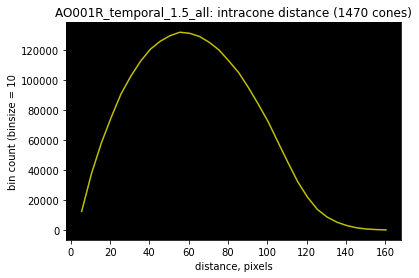

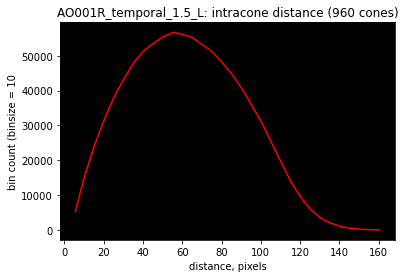

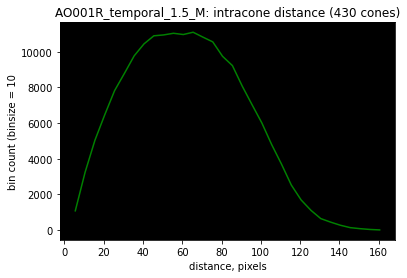

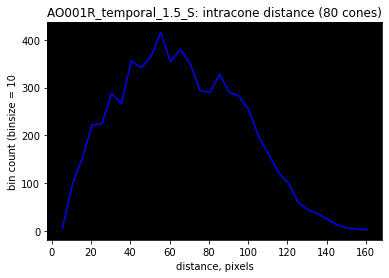

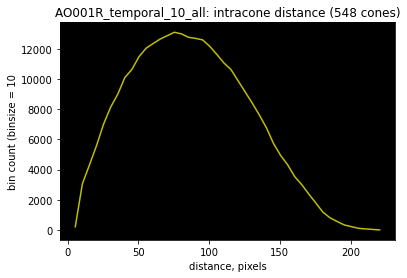

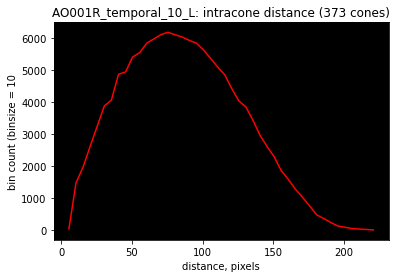

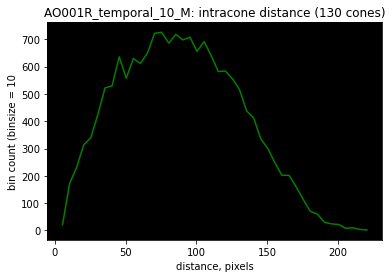

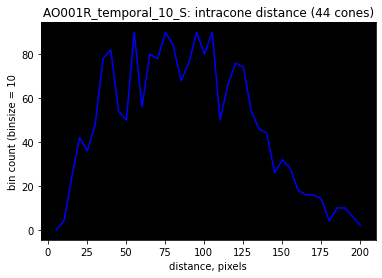

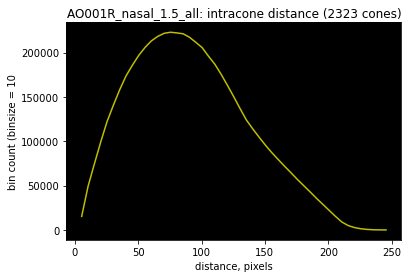

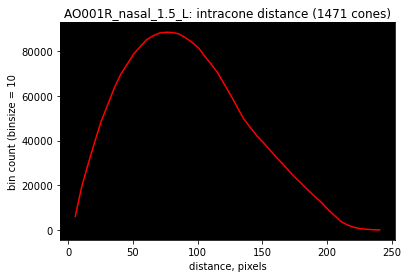

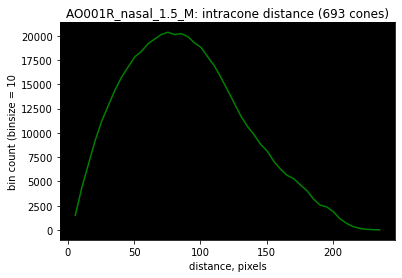

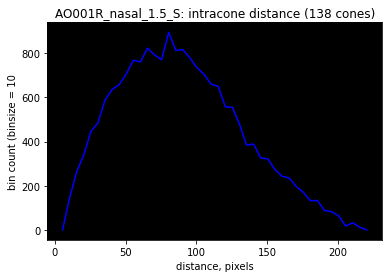

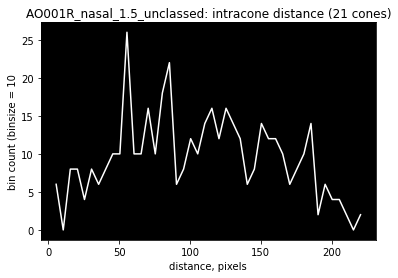

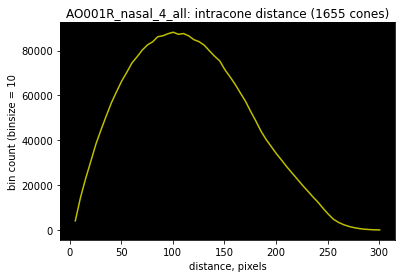

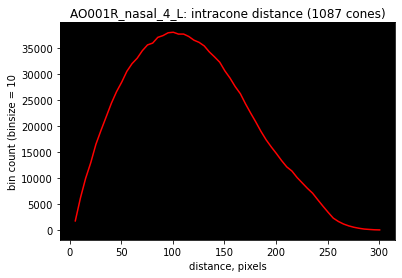

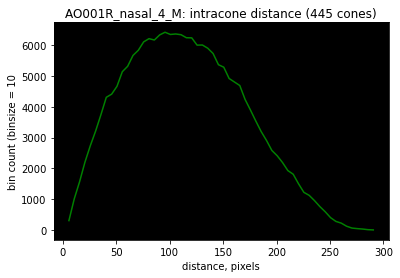

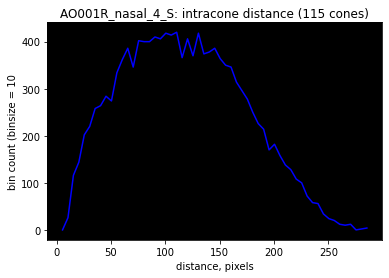

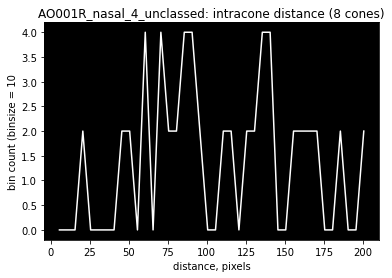

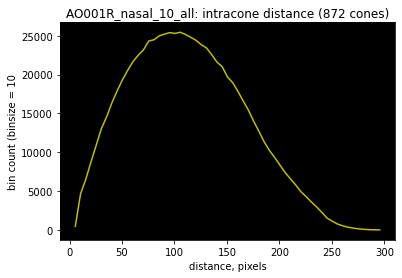

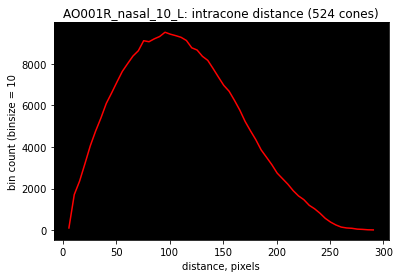

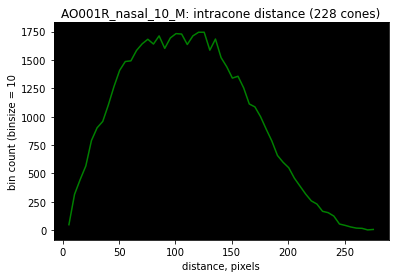

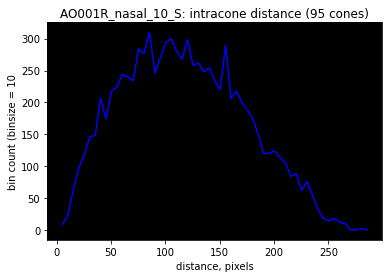

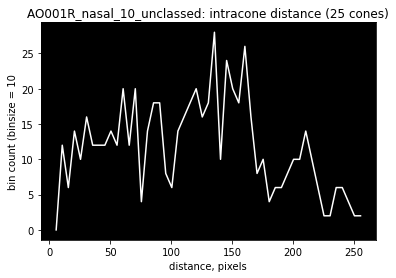

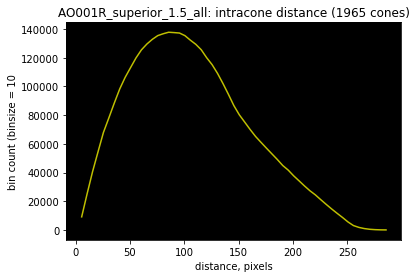

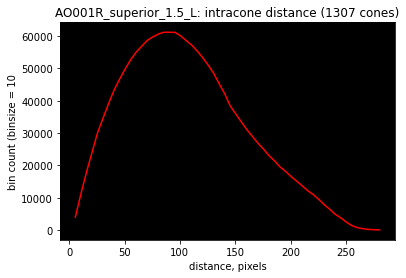

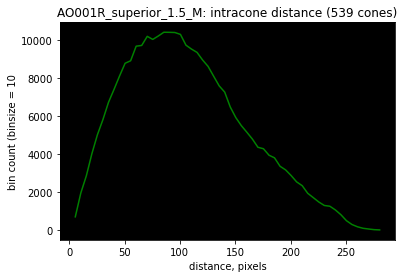

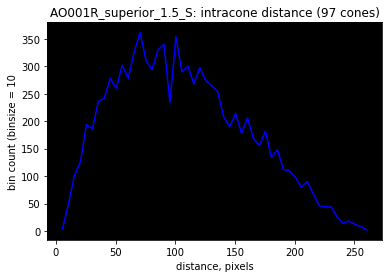

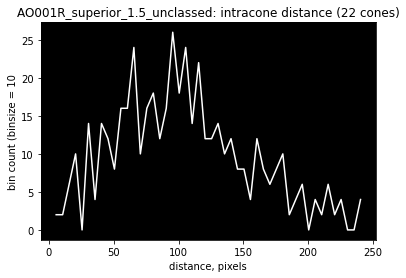

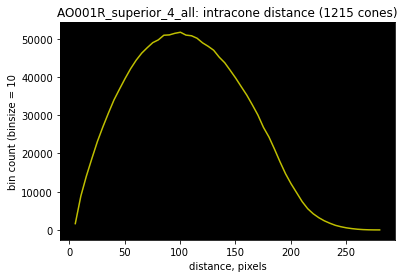

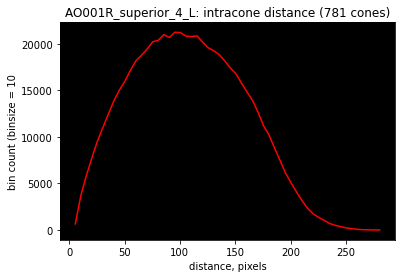

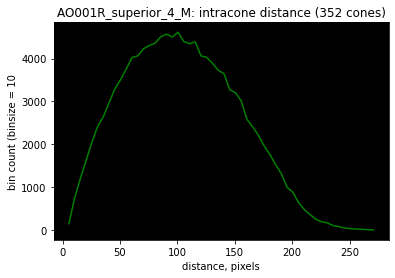

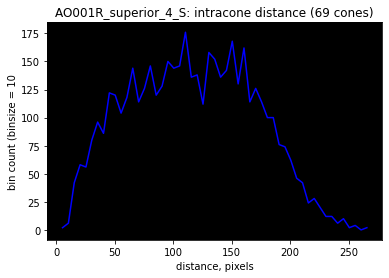

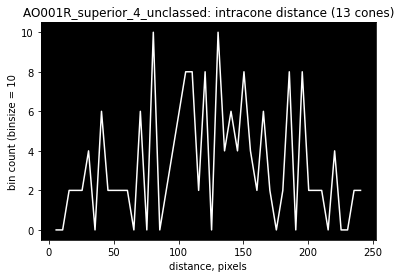

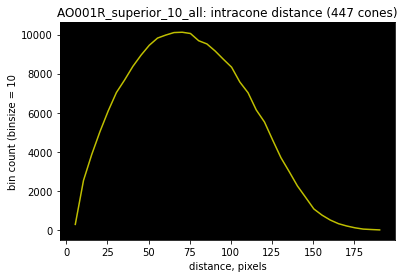

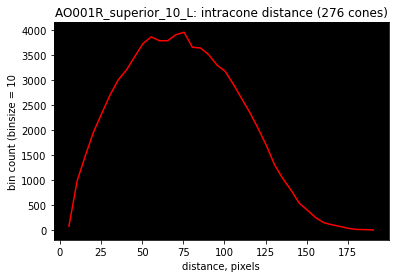

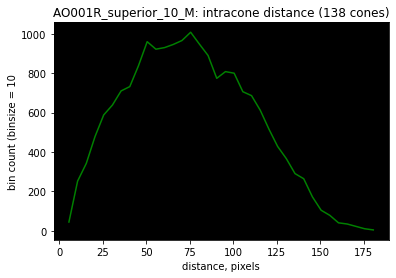

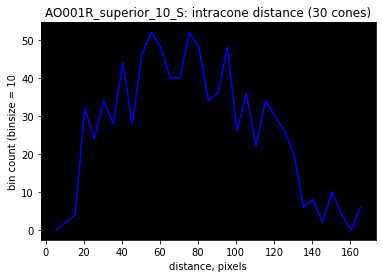

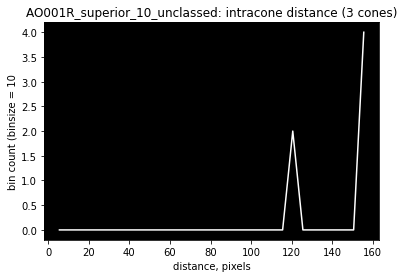

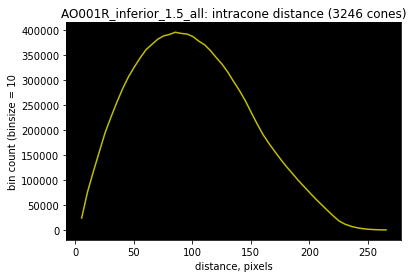

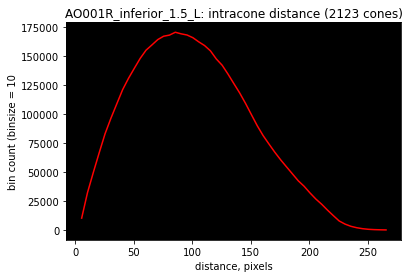

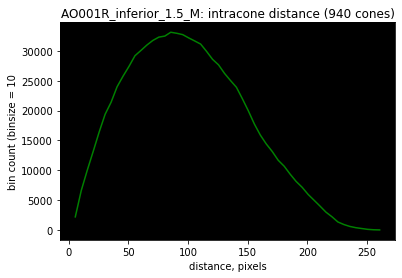

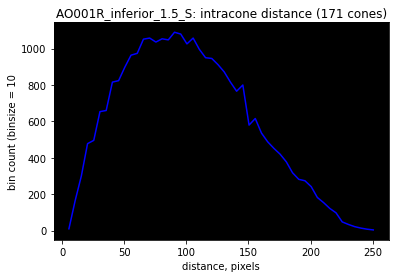

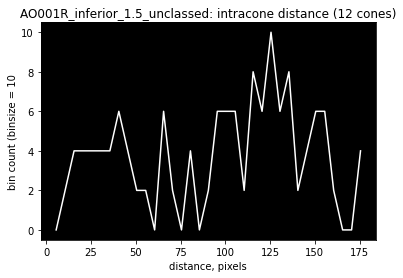

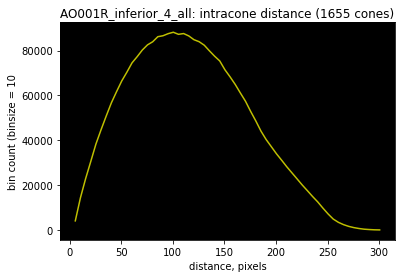

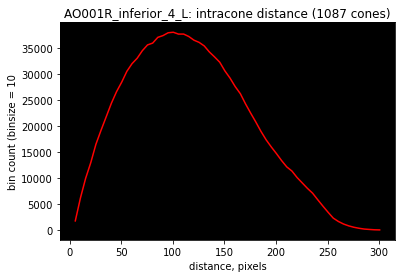

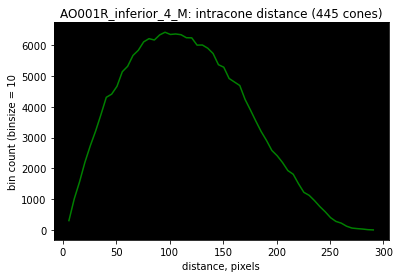

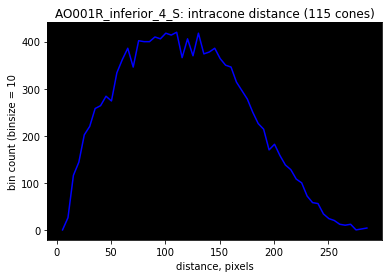

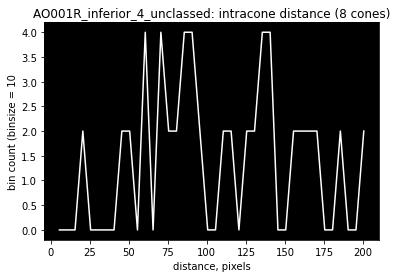

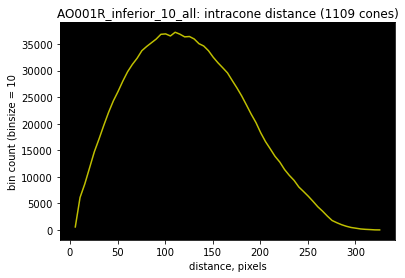

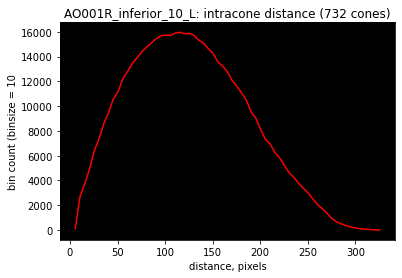

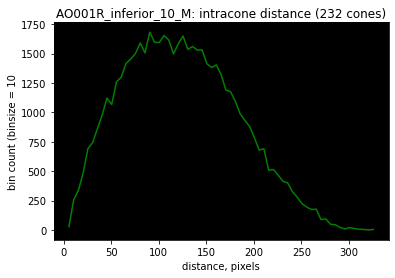

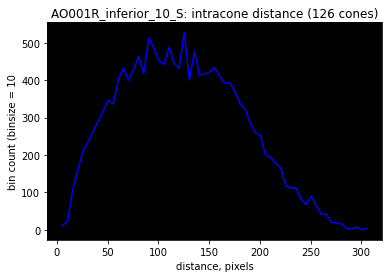

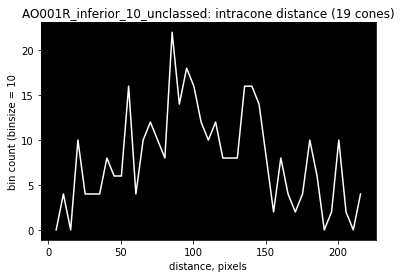

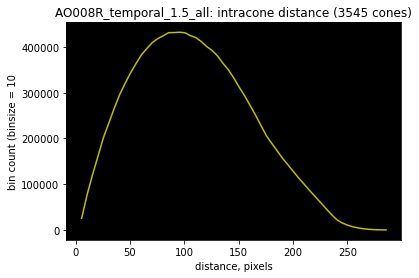

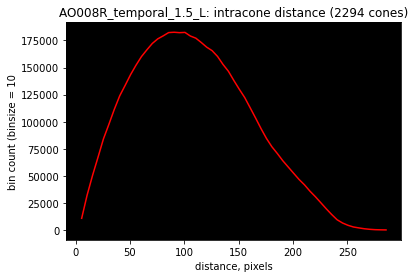

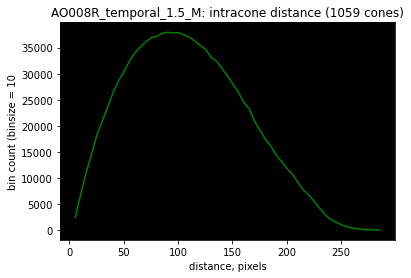

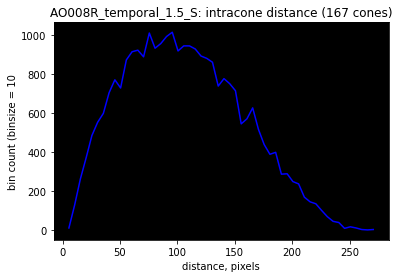

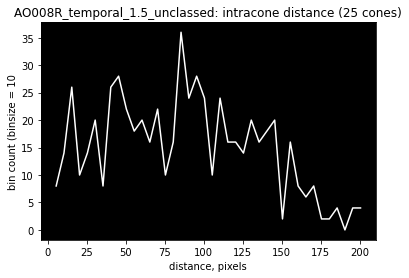

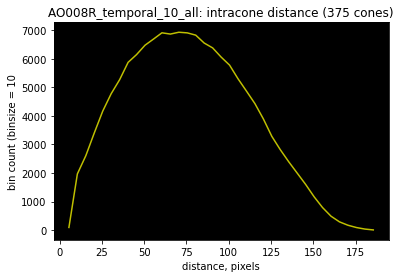

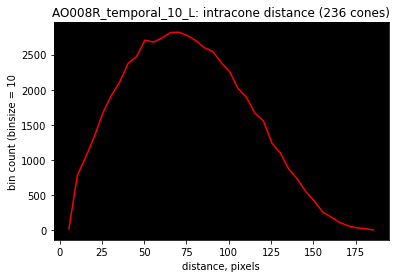

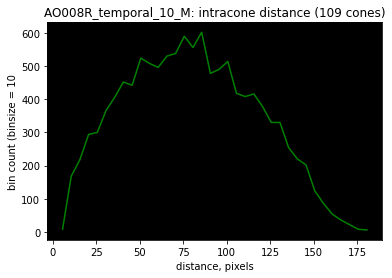

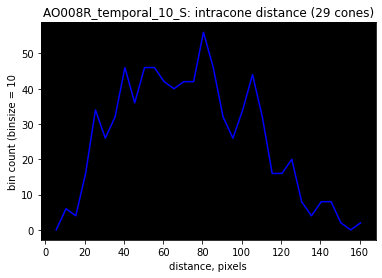

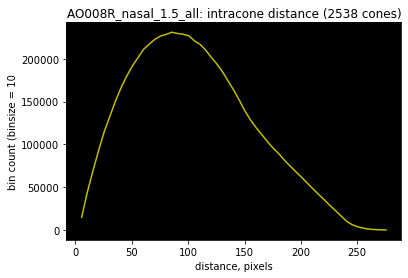

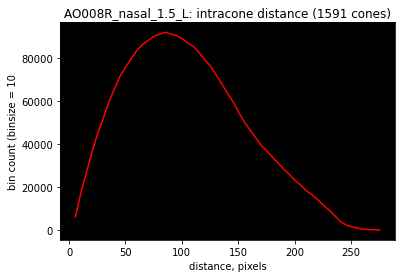

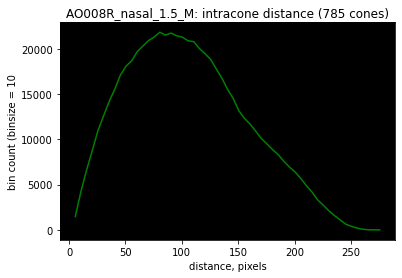

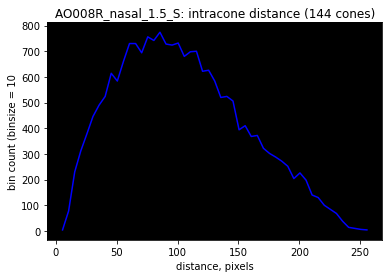

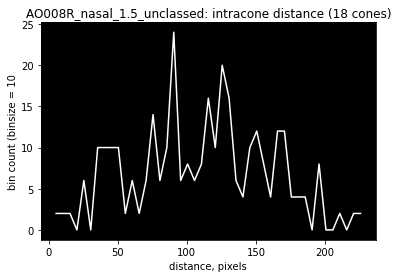

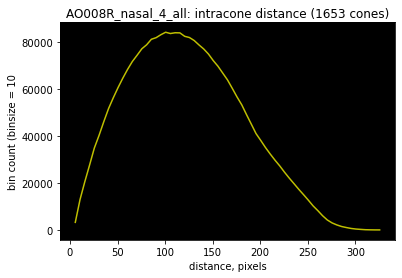

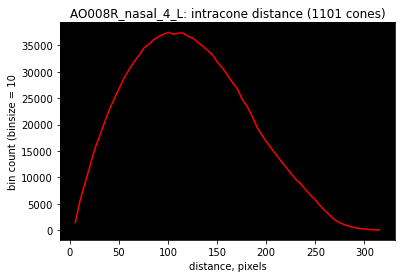

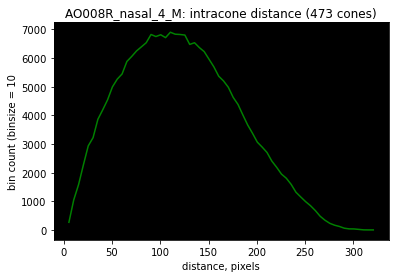

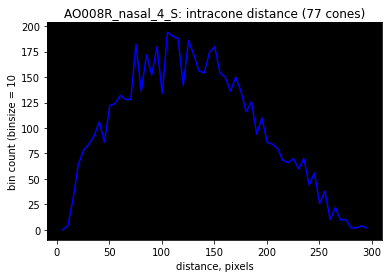

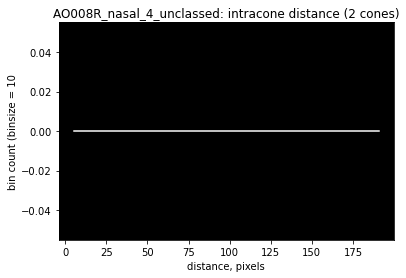

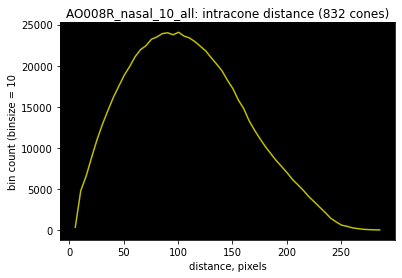

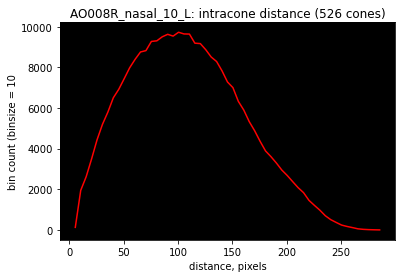

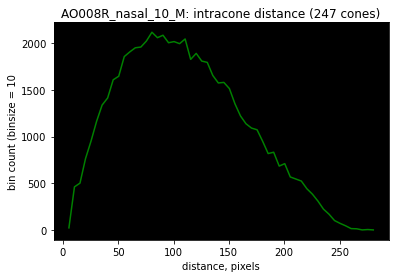

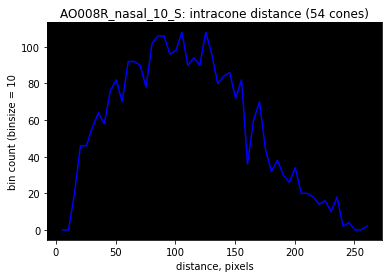

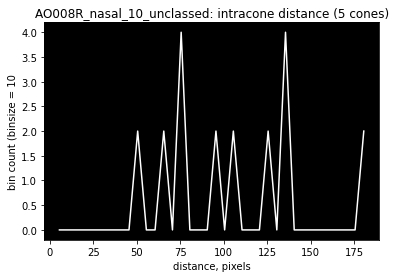

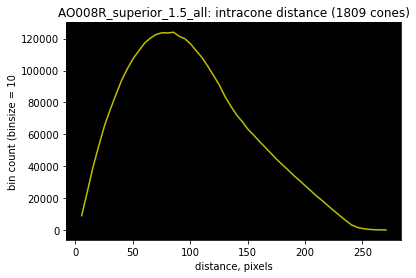

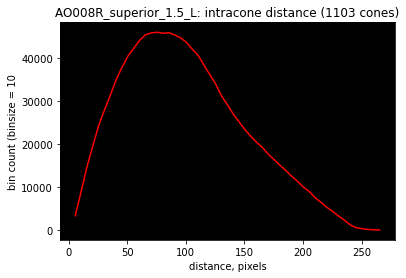

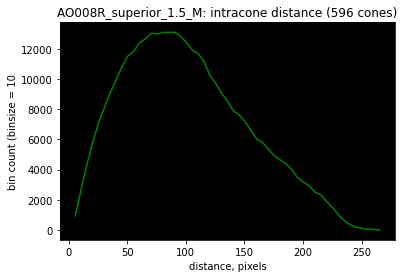

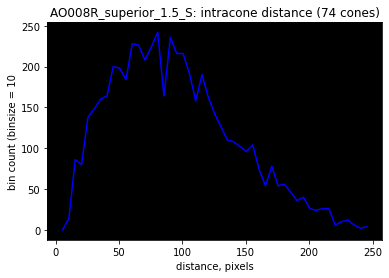

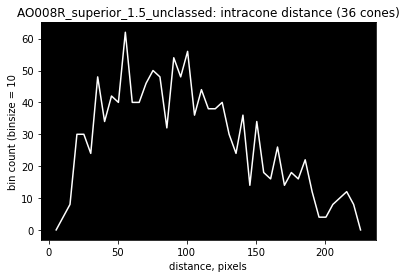

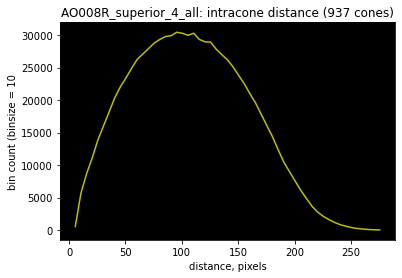

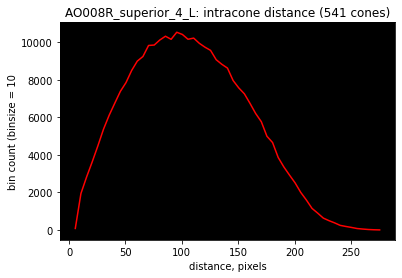

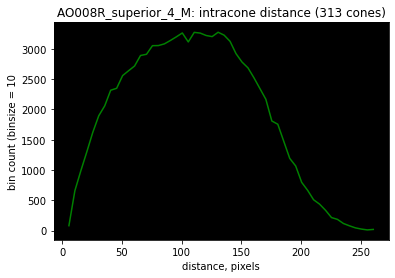

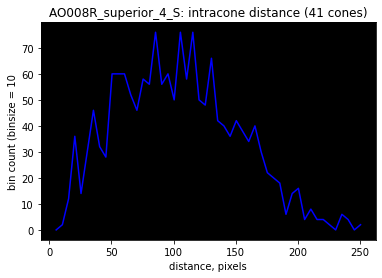

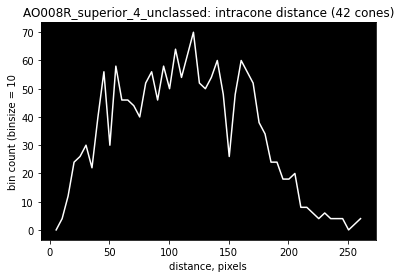

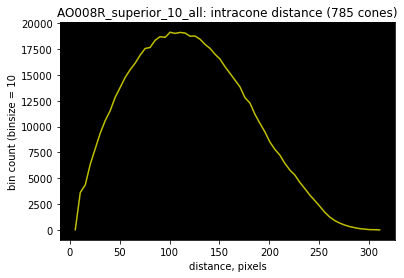

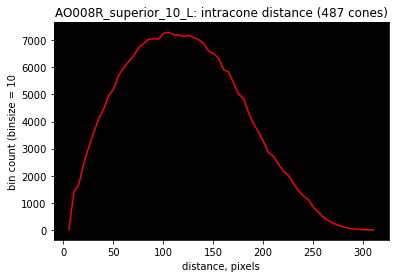

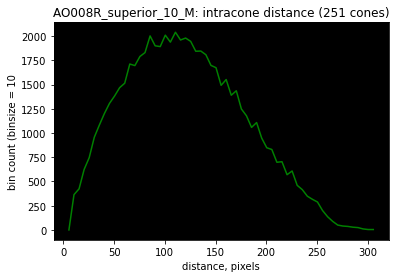

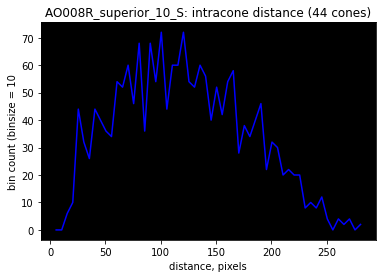

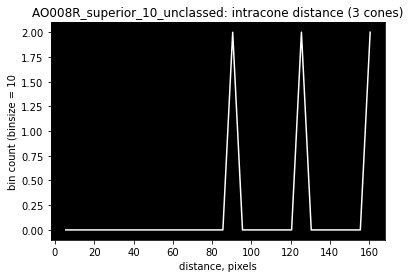

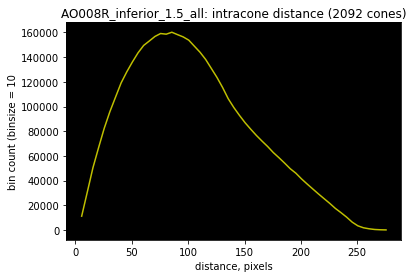

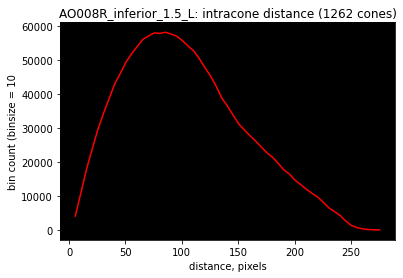

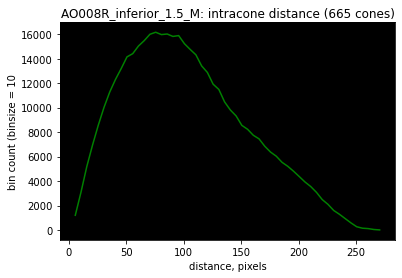

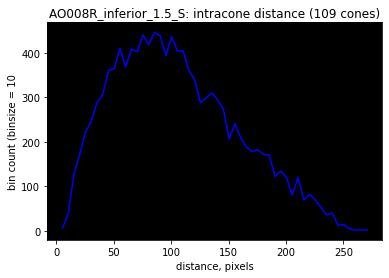

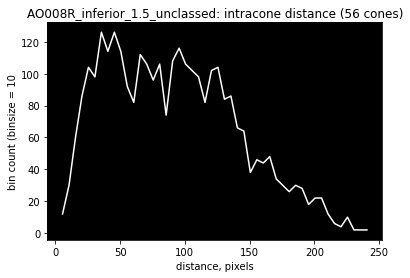

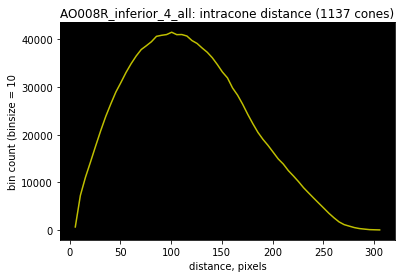

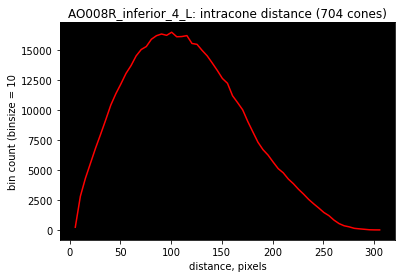

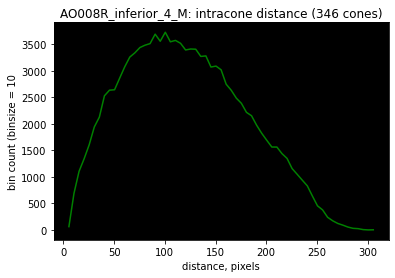

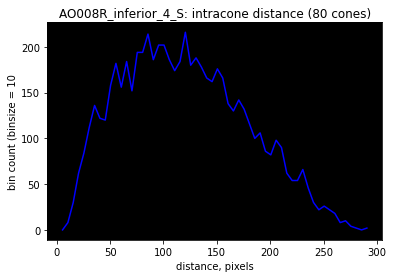

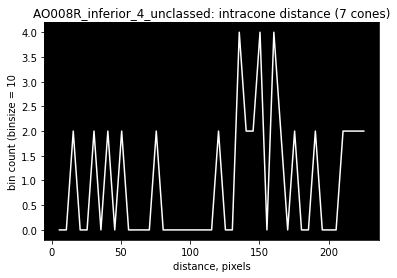

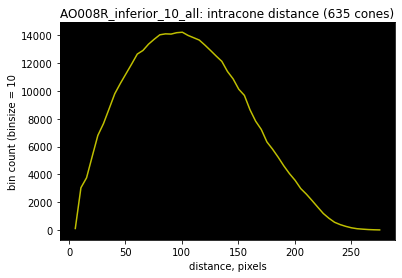

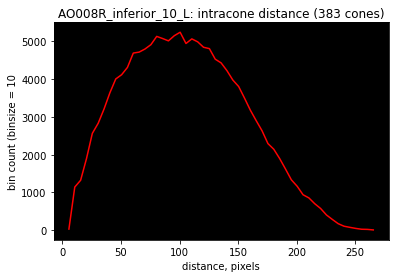

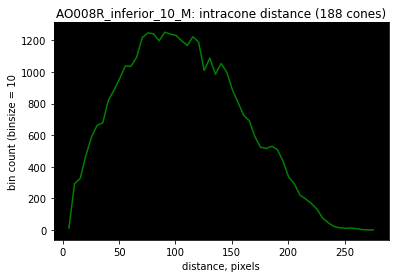

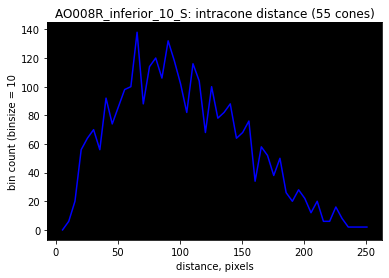

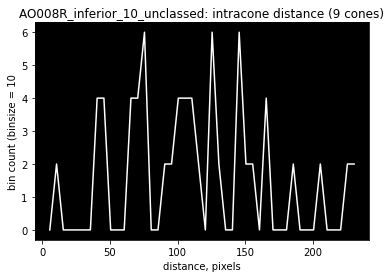

In [9]:
smp.viewIntraconeDistHists(save_name)

In [10]:
sav_fl = save_path + 'AO001R_inferior_1.5_all.hdf5'
flsyst.printSaveFile(sav_fl)

C:\Users\schle\Documents\Incubator Data\AO001R_inferior_1.5_all.hdf5
***************************************input_data***************************************
bin_width
10

cone_coord
[[174. 116.]
 [ 63.  25.]
 [105. 372.]
 ...
 [ 52. 146.]
 [263. 299.]
 [ 94. 271.]]

cone_img
[[0.18039216 0.19215687 0.18431373 ... 0.28627452 0.2627451  0.24313726]
 [0.18431373 0.1882353  0.16470589 ... 0.24705882 0.2509804  0.25882354]
 [0.26666668 0.23921569 0.1764706  ... 0.21960784 0.24313726 0.25490198]
 ...
 [0.29411766 0.28627452 0.24313726 ... 0.17254902 0.17254902 0.21568628]
 [0.3647059  0.34901962 0.28627452 ... 0.15294118 0.14901961 0.16470589]
 [0.39607844 0.36862746 0.29803923 ... 0.15686275 0.14509805 0.14117648]]

conetype_color
y

coord_unit
pixels

dist_area_norm
0

num_mc
100

***************************************intracone_dist***************************************
annulus_area
[  376.99111843  1005.30964915  1633.62817987  2261.94671058
  2890.2652413   3518.58377202  4146.9023027

In [11]:
file.close()

NameError: name 'file' is not defined